
===== Original Bipartite =====
Nodes: 2141, Edges: 24227
Pokémon Degree Range: 0 - 1235
Mean Degree: 26.77
Mean Clustering (Projection): 0.6377
Assortativity (Projection): -0.0937
Avg Path Length (Largest Component): 1.72


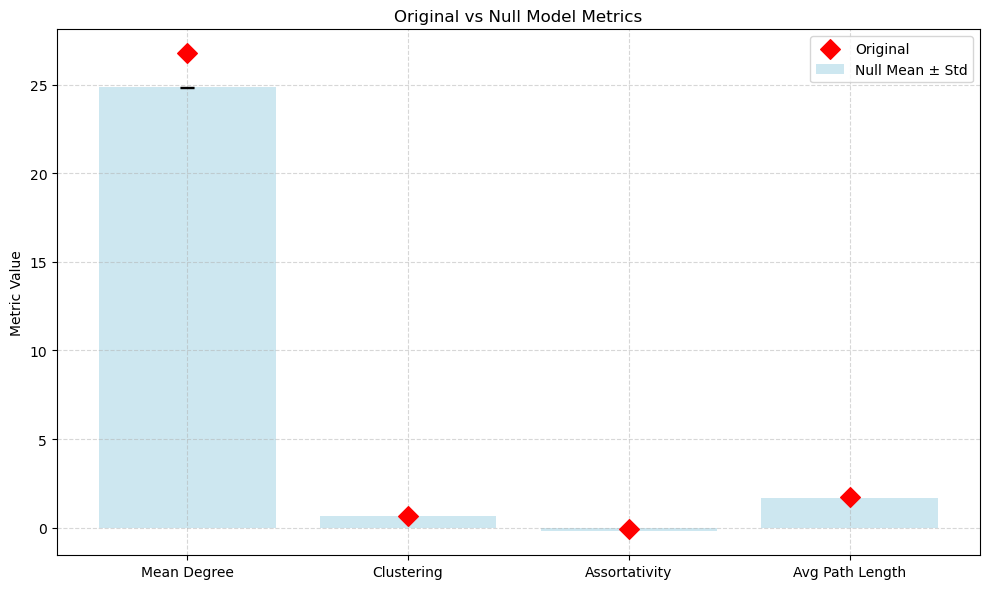

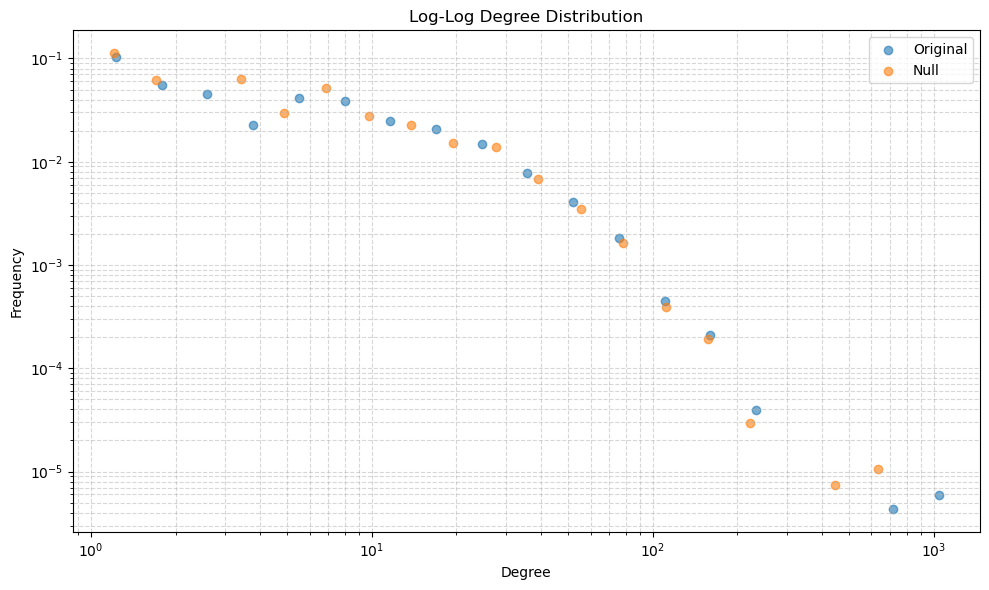

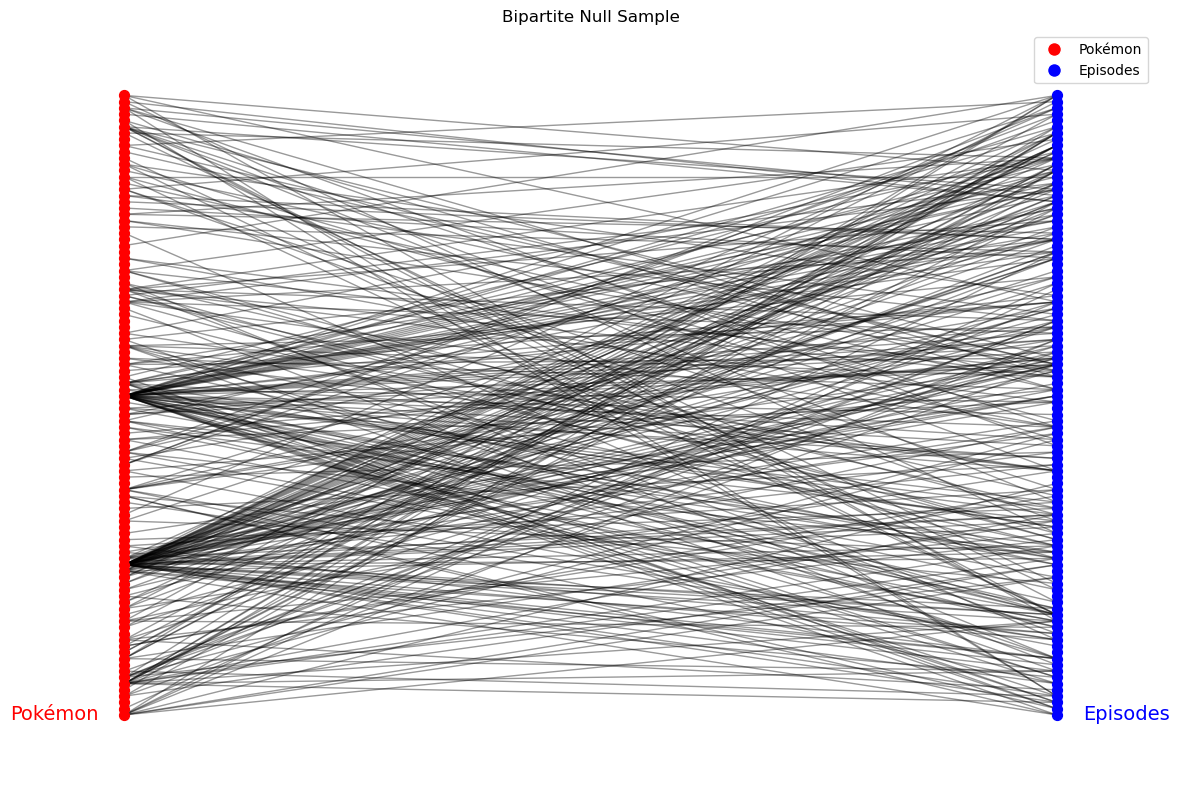

Top 3 Pokémon by Degree (Null Model):
1. Pikachu - Degree: 740
2. Meowth - Degree: 628
3. Wobbuffet - Degree: 499

===== Average Null Stats =====
Mean Degree: 24.8620
Clustering: 0.6635
Assortativity: -0.2080
Avg Path Length: 1.6891


In [26]:
# --- Imports ---
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from networkx.algorithms import bipartite

# --- Load Data ---
pokemon_df = pd.read_csv('../../datasets/clean/pokemon_nodes.csv')
episodes_df = pd.read_csv('../../datasets/clean/episode_nodes.csv')
pokemon_ids = set(pokemon_df['Id'])
episode_ids = set(episodes_df['Id'])

# --- Build Original Bipartite Graph ---
G_real = nx.Graph()
G_real.add_nodes_from(pokemon_ids, bipartite=0)
G_real.add_nodes_from(episode_ids, bipartite=1)

edges = nx.read_edgelist('../../datasets/clean/edge_list.csv', delimiter=',', nodetype=int, encoding='utf-8', comments='Source')
G_real.add_edges_from(edges.edges())

# --- Degree Sequences ---
pokemon_degrees = [G_real.degree(n) for n in pokemon_ids]
episode_degrees = [G_real.degree(n) for n in episode_ids]

# --- Projected Pokémon Graph ---
real_proj = bipartite.projected_graph(G_real, pokemon_ids)

# --- Summarize Graph ---
def summarize_graph(name, G_bip, G_proj, nodes):
    degrees = [G_bip.degree(n) for n in nodes]
    print(f"\n===== {name} =====")
    print(f"Nodes: {G_bip.number_of_nodes()}, Edges: {G_bip.number_of_edges()}")
    print(f"Pokémon Degree Range: {min(degrees)} - {max(degrees)}")
    print(f"Mean Degree: {np.mean(degrees):.2f}")
    print(f"Mean Clustering (Projection): {nx.average_clustering(G_proj):.4f}")
    print(f"Assortativity (Projection): {nx.degree_assortativity_coefficient(G_proj):.4f}")
    
    if nx.is_connected(G_proj):
        print(f"Avg Path Length: {nx.average_shortest_path_length(G_proj):.2f}")
    else:
        largest_cc = max(nx.connected_components(G_proj), key=len)
        subgraph = G_proj.subgraph(largest_cc)
        print(f"Avg Path Length (Largest Component): {nx.average_shortest_path_length(subgraph):.2f}")

summarize_graph("Original Bipartite", G_real, real_proj, pokemon_ids)

# --- Collect Stats Helper ---
def collect_stats(G_bip, G_proj, nodes, sample_size=1000):
    degrees = [G_bip.degree(n) for n in nodes]
    
    sample_nodes = random.sample(list(G_proj.nodes()), min(sample_size, len(G_proj)))
    clustering = nx.average_clustering(G_proj, nodes=sample_nodes)
    assortativity = nx.degree_assortativity_coefficient(G_proj)

    if nx.is_connected(G_proj):
        path_len = nx.average_shortest_path_length(G_proj)
    else:
        largest_cc = max(nx.connected_components(G_proj), key=len)
        path_len = nx.average_shortest_path_length(G_proj.subgraph(largest_cc))

    return [np.mean(degrees), clustering, assortativity, path_len]

# --- Null Model Ensemble ---
NUM_NULLS = 20
null_stats = []

for _ in range(NUM_NULLS):
    G_null = bipartite.configuration_model(pokemon_degrees, episode_degrees)
    G_null = nx.Graph(G_null)  # Removes parallel edges
    G_null.remove_edges_from(nx.selfloop_edges(G_null))

    null_nodes = list(range(len(pokemon_degrees)))
    null_proj = bipartite.projected_graph(G_null, null_nodes)

    stats = collect_stats(G_null, null_proj, null_nodes)
    null_stats.append(stats)

null_df = pd.DataFrame(null_stats, columns=["Mean Degree", "Clustering", "Assortativity", "Avg Path Length"])
orig_stats = collect_stats(G_real, real_proj, pokemon_ids)

# --- Plot Comparison ---
def plot_stat_comparison(original_stats, null_df):
    metrics = null_df.columns
    means = null_df.mean()
    stds = null_df.std()

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, means, yerr=stds, capsize=5, alpha=0.6, label="Null Mean ± Std", color='lightblue')
    plt.scatter(metrics, original_stats, color='red', label="Original", zorder=5, s=100, marker='D')
    plt.ylabel("Metric Value")
    plt.title("Original vs Null Model Metrics")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_stat_comparison(orig_stats, null_df)

# --- Log-Log Degree Distribution Plot ---
def plot_degree_distributions(G1, G2, nodes1, nodes2, bins=20, label1='Original', label2='Null'):
    def log_binned(degrees, bins):
        degrees = np.array(degrees)
        degrees = degrees[degrees > 0]
        log_bins = np.logspace(np.log10(degrees.min()), np.log10(degrees.max()), bins)
        hist, bin_edges = np.histogram(degrees, bins=log_bins, density=True)
        centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        return centers, hist

    degs1 = [G1.degree(n) for n in nodes1]
    degs2 = [G2.degree(n) for n in nodes2]
    
    x1, y1 = log_binned(degs1, bins)
    x2, y2 = log_binned(degs2, bins)

    plt.figure(figsize=(10, 6))
    plt.scatter(x1, y1, label=label1, alpha=0.6)
    plt.scatter(x2, y2, label=label2, alpha=0.6)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Log-Log Degree Distribution')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Recreate a sample null model for visualization
# Recreate a sample null model for visualization
G_null_sample = bipartite.configuration_model(pokemon_degrees, episode_degrees)
G_null_sample = nx.Graph(G_null_sample)
G_null_sample.remove_edges_from(nx.selfloop_edges(G_null_sample))

# --- 🔁 Relabel nodes to match Pokémon and Episode IDs ---
pokemon_id_list = list(pokemon_ids)
episode_id_list = list(episode_ids)

mapping = {}
for i, node in enumerate(G_null_sample.nodes()):
    if i < len(pokemon_id_list):
        mapping[node] = pokemon_id_list[i]
    else:
        mapping[node] = episode_id_list[i - len(pokemon_id_list)]

G_null_sample = nx.relabel_nodes(G_null_sample, mapping)

# Redefine null_sample_ids to reflect actual Pokémon IDs
null_sample_ids = pokemon_id_list

plot_degree_distributions(G_real, G_null_sample, pokemon_ids, null_sample_ids)

# --- Optional: Visualize Sample Bipartite Graph ---
def draw_bipartite_graph(G, pokemon_nodes, title, num_nodes=100):
    import matplotlib.pyplot as plt

    # Filter valid nodes with degrees > 0
    pokemon_nodes_to_draw = [n for n in pokemon_nodes if G.degree(n) > 0][:num_nodes]
    episode_nodes_to_draw = [n for n in set(G.nodes()) - set(pokemon_nodes) if G.degree(n) > 0][:num_nodes]

    # Subgraph of the selected nodes
    subgraph = G.subgraph(pokemon_nodes_to_draw + episode_nodes_to_draw)
    pos = nx.bipartite_layout(subgraph, pokemon_nodes_to_draw)

    plt.figure(figsize=(12, 8))

    # Draw Pokémon (red)
    nx.draw_networkx_nodes(subgraph, pos,
                           nodelist=pokemon_nodes_to_draw,
                           node_color='red',
                           node_size=50,
                           label='Pokémon')

    # Draw Episodes (blue)
    nx.draw_networkx_nodes(subgraph, pos,
                           nodelist=episode_nodes_to_draw,
                           node_color='blue',
                           node_size=50,
                           label='Episodes')

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, alpha=0.4)

    # Add side labels
    if pokemon_nodes_to_draw:
        plt.text(pos[pokemon_nodes_to_draw[0]][0] - 0.15,
                 pos[pokemon_nodes_to_draw[0]][1],
                 'Pokémon', fontsize=14, ha='center', va='center', color='red')
    if episode_nodes_to_draw:
        plt.text(pos[episode_nodes_to_draw[0]][0] + 0.15,
                 pos[episode_nodes_to_draw[0]][1],
                 'Episodes', fontsize=14, ha='center', va='center', color='blue')

    # Add legend
    red_patch = plt.Line2D([0], [0], marker='o', color='w',
                           markerfacecolor='red', markersize=10, label='Pokémon')
    blue_patch = plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='blue', markersize=10, label='Episodes')
    plt.legend(handles=[red_patch, blue_patch], loc='upper right')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


draw_bipartite_graph(G_null_sample, null_sample_ids, "Bipartite Null Sample")

# --- Top 3 Pokémon from Null ---
top_null_ids = sorted(null_sample_ids, key=lambda x: G_null_sample.degree(x), reverse=True)[:3]
print("Top 3 Pokémon by Degree (Null Model):")
for i, node in enumerate(top_null_ids, 1):
    if node in pokemon_df['Id'].values:
        name = pokemon_df.loc[pokemon_df['Id'] == node, 'Label'].values[0]
    else:
        name = f"Unknown (ID: {node})"
    print(f"{i}. {name} - Degree: {G_null_sample.degree(node)}")

# --- Summary of Null Stats ---
avg_stats = null_df.mean()
print("\n===== Average Null Stats =====")
for col in null_df.columns:
    print(f"{col}: {avg_stats[col]:.4f}")


# Convert edges to DataFrame
edge_list_df = pd.DataFrame(G_null_sample.edges(), columns=['Source', 'Target'])

# Export to CSV
edge_list_df.to_csv('null_model_edge_list.csv', index=False)



